In [1]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.fake_provider import FakeMelbourneV2, FakeVigoV2
from qiskit.quantum_info import Pauli
from qiskit_aer.noise import NoiseModel, pauli_error
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
import json

sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "pauli_lindblad_per"))

from tomography.experiment import SparsePauliTomographyExperiment as tomography
from primitives.pauli import QiskitPauli

plt.style.use("ggplot")

In [2]:
backend = FakeVigoV2()

In [3]:
twoqubit_errorops = [Pauli('YX'), Pauli('ZI'), Pauli('XZ'), Pauli('IX'), Pauli('IZ')] 
# The respective chance for the Pauli errors is choosen. The two lists need to be equal in length
twoqubit_errorprobs = [0.005, 0.00864, 0.00564, 0.001976124, 0.009012] 
# Create *normalized* error model.
twoqubit_error_template = [(op, p) for op,p in zip(twoqubit_errorops, twoqubit_errorprobs)]+[(Pauli("II"), 1-sum(twoqubit_errorprobs))]
twoqubit_error = pauli_error(twoqubit_error_template)

noise_model = NoiseModel()
#add error model to two-qubit gates.
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])

In [4]:
def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(2*n)
    trotterLayer.rx(dt*4*h, range(2*n))
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [2*i+1 for i in range(n)])
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [2*i+2 for i in range(n-1)])
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    return trotterLayer

h = 1 
J = -.15
dt = .2 # time stepsize
n = 2 # amount of qubits halfed

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(n*2)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    trotterCircuit = transpile(trotterCircuit, backend) # transpiling swaps gates for backend native gates and optimizes the code by removing and combining unnessesary gates
    return trotterCircuit

circuits = [maketrotterCircuit(i) for i in range(1,15)]
print(circuits[0].draw(fold=-1))

                                                                                                                         
ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────────────────────
               ┌─────────┐┌────┐┌──────────────────────┐┌────┐┌──────────┐┌───┐┌──────────┐┌───┐                       ░ 
      q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├┤ X ├┤ Rz(0.12) ├┤ X ├──■────────────────■───░─
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤└─┬─┘└──────────┘└─┬─┘  │                │   ░ 
      q_0 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├──■────────────────■────┼────────────────┼───░─
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤                      ┌─┴─┐┌──────────┐┌─┴─┐ ░ 
      q_2 -> 3 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├──■────────────────■──┤ X ├┤ Rz(0.12) ├┤ X ├─░─
               ├────────

In [5]:
def executor(circuits, backend, shots, noise_model=None):
	return backend.run(circuits, shots=shots).result().get_counts()

In [6]:
def executor2(circuits, backend, shots, noise_model=None):
	#for circ in circuits:
	print(circuits[0].draw(fold=-1))
	return backend.run(circuits, shots=shots).result().get_counts()

In [7]:
experiment = tomography(circuits = circuits, inst_map = [0,1,2,3,4], backend = backend, sum_over_lambda=False)

In [8]:
experiment.generate(samples = 16, single_samples = 100, depths = [2,4,8,16])

In [9]:
experiment.run(executor, 1024, noise_model=noise_model)

In [10]:
noisedataframe = experiment.analyze()

In [11]:
perexp = experiment.create_per_experiment(circuits)

In [15]:
noise_strengths = [0,0.5,1,2]
expectations = ["ZIIII", "IZIII","IIZII","IIIZI"]#,"IIIIZ"]
perexp.generate(expectations = expectations, samples = 5, noise_strengths = noise_strengths)

## PER

In [16]:
perexp.run(executor2, shots=1024, noise_model=noise_model)

                                                                           ░ ┌───┐┌───┐┌───┐      ░              ░ ┌───┐┌───┐┌───┐      ░  ░ ┌───┐┌───┐┌───┐      ░              ░ ┌───┐┌───┐┌───┐      ░ ┌───┐ ░ ┌─┐            
ancilla_0 -> 0 ────────────────────────────────────────────────────────────░─┤ X ├┤ I ├┤ X ├──────░──────────────░─┤ Y ├┤ I ├┤ Y ├──────░──░─┤ X ├┤ I ├┤ X ├──────░──────────────░─┤ I ├┤ I ├┤ I ├──────░─┤ X ├─░─┤M├────────────
               ┌─────────┐┌────┐┌──────────────────────┐┌────┐┌──────────┐ ░ ├───┤├───┤├───┤┌───┐ ░ ┌──────────┐ ░ ├───┤├───┤├───┤┌───┐ ░  ░ ├───┤├───┤└───┘┌───┐ ░              ░ ├───┤├───┤└───┘┌───┐ ░ ├───┤ ░ └╥┘┌─┐         
      q_1 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(3.94159265358979) ├┤ √X ├┤ Rz(5π/2) ├─░─┤ I ├┤ I ├┤ X ├┤ X ├─░─┤ Rz(0.12) ├─░─┤ Y ├┤ I ├┤ X ├┤ Y ├─░──░─┤ I ├┤ I ├──■──┤ I ├─░──────────────░─┤ Y ├┤ I ├──■──┤ Y ├─░─┤ I ├─░──╫─┤M├─────────
               ├─────────┤├────┤├──────────────────────┤├────┤├──────────┤ ░ ├───┤├───┤└─┬─┘├───

In [17]:
circuit_results = perexp.analyze()

In [18]:
results_errors = []
results_at_noise = []
results_at_noise_errors = []
results = []

for run in circuit_results:
	tot = 0
	tot_error = 0
	tot_at_noise = [0 for _ in range(len(noise_strengths))]
	tot_at_noise_errors = [0 for _ in range(len(noise_strengths))]
	for op in expectations:
		#get the full per results
		expec = run.get_result(op).expectation
		tot += expec/len(expectations)
		print((expec, op))

		#get the corresponding fit-errors
		expec_error = run.get_result(op).expectation_error
		tot_error += expec_error/len(expectations)

		#get the value at the different noise levels
		expec_at_noise = run.get_result(op).get_expectations()
		for i in range(0,len(tot_at_noise)):
			tot_at_noise[i] += expec_at_noise[i]/len(expectations)

		expec_at_noise_error = [run.get_result(op).get_std_of_strengths(strength) for strength in noise_strengths]
		for i in range(0,len(tot_at_noise)):
			tot_at_noise_errors[i] += expec_at_noise_error[i]/len(expectations)

	results.append(tot)
	results_errors.append(tot_error)
	results_at_noise.append(tot_at_noise)
	results_at_noise_errors.append(tot_at_noise_errors)

savi = {}
savi["results"] = results
savi["results_errors"] = results_errors
savi["results_at_noise"] = results_at_noise
savi["results_at_noise_errors"] = results_at_noise_errors


(0.745193562081059, 'ZIIII')
(0.7409275456164053, 'IZIII')
(0.70621118982475, 'IIZII')
(0.7629768446165514, 'IIIZI')
(-0.6560869347697256, 'ZIIII')
(-0.6949727052299236, 'IZIII')
(-0.669131183797952, 'IIZII')
(-0.7581210269989488, 'IIIZI')
(-1.4999999999999998, 'ZIIII')
(-1.2458052579647776, 'IZIII')
(-1.0835012700048035, 'IIZII')
(-1.4081561915758483, 'IIIZI')
(-0.012477106348493505, 'ZIIII')
(-0.016398662998465638, 'IZIII')
(-0.025159191451035113, 'IIZII')
(-0.01803884219918915, 'IIIZI')
(-0.8682758758396764, 'ZIIII')
(-0.480248571736817, 'IZIII')
(-0.5671429094016872, 'IIZII')
(-0.6502678111434694, 'IIIZI')
(1.0246264894944146, 'ZIIII')
(0.6475140490198001, 'IZIII')
(0.9687604782241328, 'IIZII')
(1.4999999973854357, 'IIIZI')
(1.1560954676659028, 'ZIIII')
(0.4133626756703387, 'IZIII')
(1.2314047809481772, 'IIZII')
(0.6233522670736461, 'IIIZI')
(0.03841740605145972, 'ZIIII')
(0.05650747281638596, 'IZIII')
(0.06576720499520194, 'IIZII')
(0.10500443866216273, 'IIIZI')
(-0.57944298759341

In [19]:
circuit_results[-1]._per_circ.overhead(0)

6.674384458992154

In [20]:
noisyresult = []
res = []
for i in range(2):
	for circ in circuits:
		qc = circ.copy()
		qc.measure_all()
		if i == 0: # Ideal results
			count= backend.run(qc, shots = 1024, noise_model=None).result().get_counts()
		else: # Unmitigated results
			count= backend.run(qc, shots=1024, noise_model=noise_model).result().get_counts()
		count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
		tot = 0
		for key in count.keys():
			num = sum([(-1)**bit for bit in key[:4]])
			tot += num*count[key]
		if i == 0: # Ideal results
			res.append(tot/(1024*n*2))
		else: # Unmitigated results
			noisyresult.append(tot/(1024*n*2))

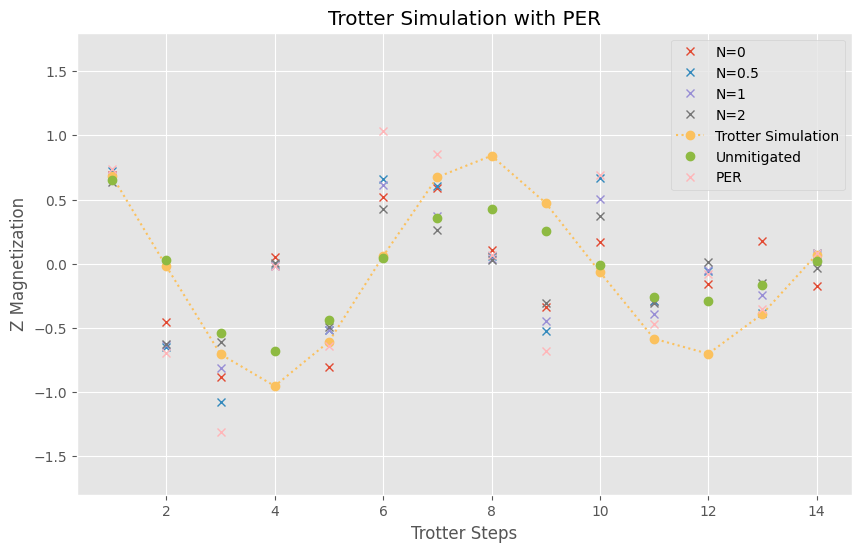

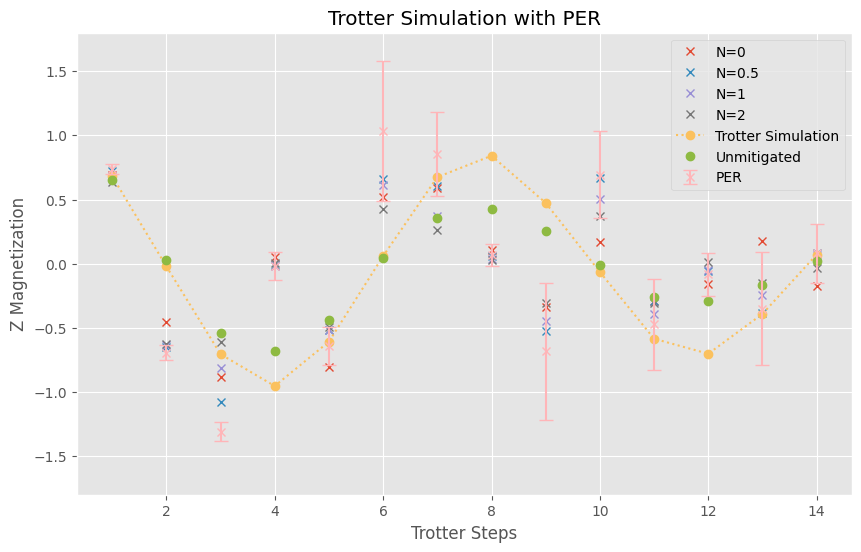

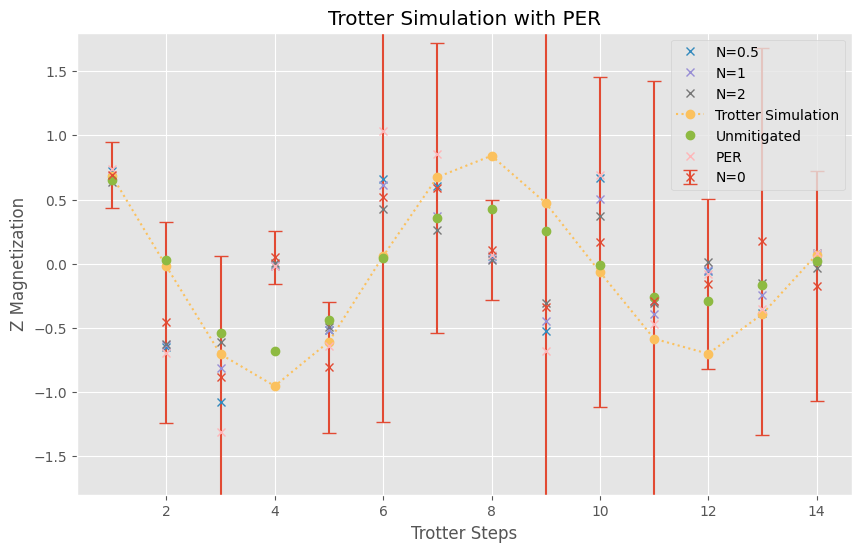

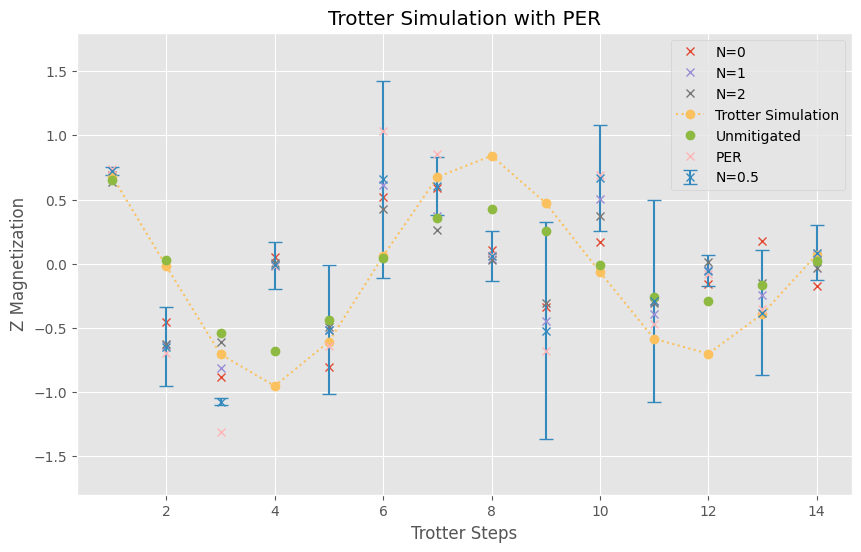

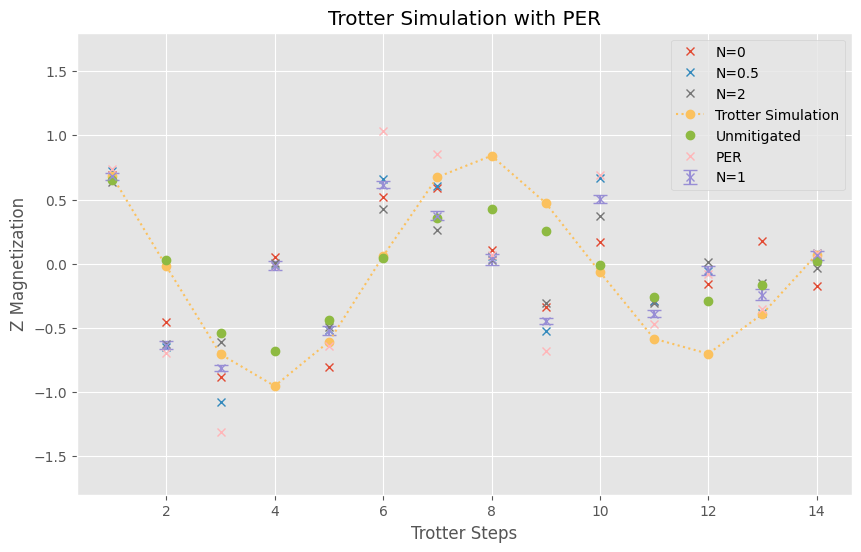

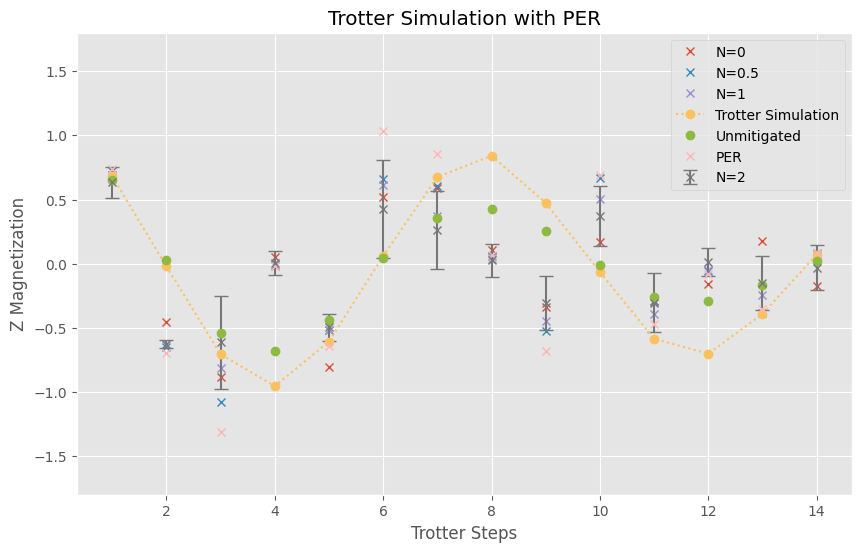

In [21]:
for j in range(len(noise_strengths)+2): # 0 vZNE results, 1-x results at noise level
	plt.figure(figsize=(10,6))
	for i, noise in enumerate(noise_strengths):
		if j != 0 and j!= 1 and noise == noise_strengths[j-2]:
			plt.errorbar(range(1,15), [res[i] for res in results_at_noise], fmt='x', yerr=[res[i] for res in results_at_noise_errors], capsize=5, label='N='+str(noise))
		else:
			plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
		
	plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
	plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
	if j == 1:
		plt.errorbar(range(1,15), results, yerr=[[np.abs(res) for res in results_errors]],fmt='x', capsize=5, label="PER")
	else:
		plt.plot(range(1,15), results, 'x', label="PER")

	plt.ylim([-1.8,1.8])
	plt.legend()
	plt.title("Trotter Simulation with PER")
	plt.xlabel("Trotter Steps")
	plt.ylabel("Z Magnetization")
	#plt.savefig("Trotter_Sim_PER.png")
	plt.show()

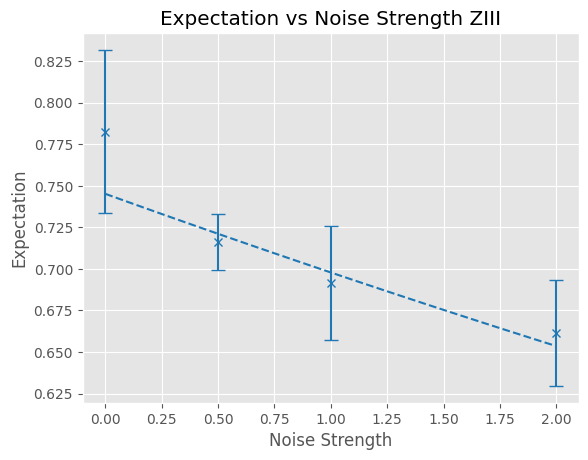

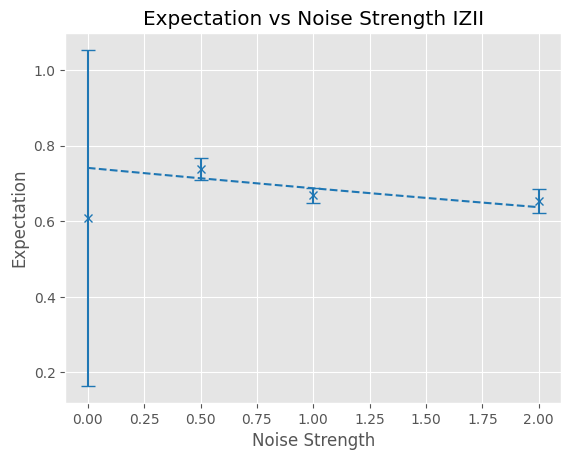

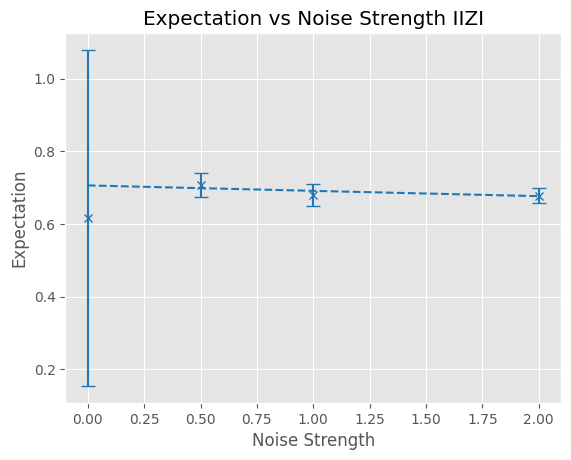

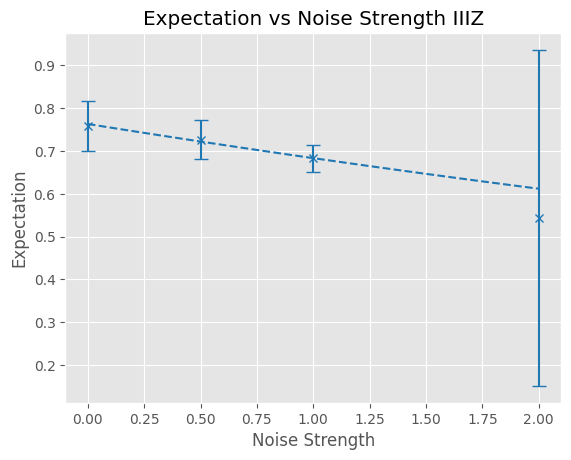

In [22]:
ax = circuit_results[0].get_result("ZIIII").plot()
plt.title('Expectation vs Noise Strength ZIII')
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.savefig("Expectation_vs_Noise_Strength_ZIII.png")
circuit_results[0].get_result("IZIII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IZII')
plt.savefig("Expectation_vs_Noise_Strength_IZII.png")
circuit_results[0].get_result("IIZII").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIZI')
plt.savefig("Expectation_vs_Noise_Strength_IIZI.png")
circuit_results[0].get_result("IIIZI").plot()
plt.xlabel("Noise Strength")
plt.ylabel("Expectation")
plt.title('Expectation vs Noise Strength IIIZ')
plt.savefig("Expectation_vs_Noise_Strength_IIIZ.png")

## Analysis

In [23]:
layer1 = experiment.analysis.get_layer_data(0)

<Axes: >

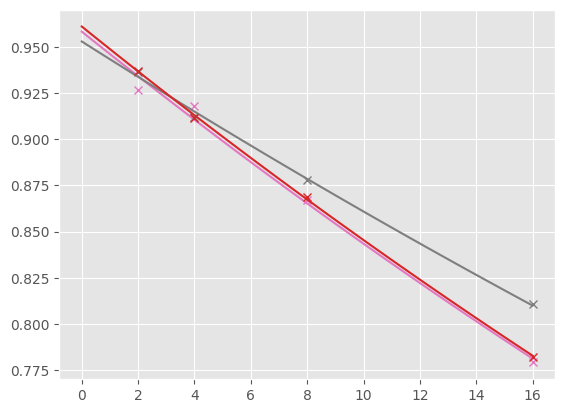

In [24]:
layer1.graph((1,))

<Axes: >

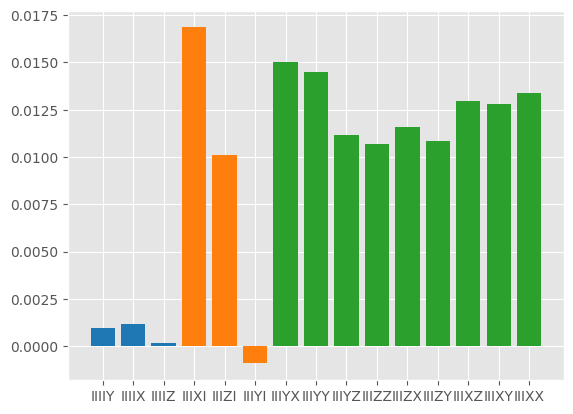

In [25]:
layer1.plot_infidelitites((0,),(1,),(0,1))

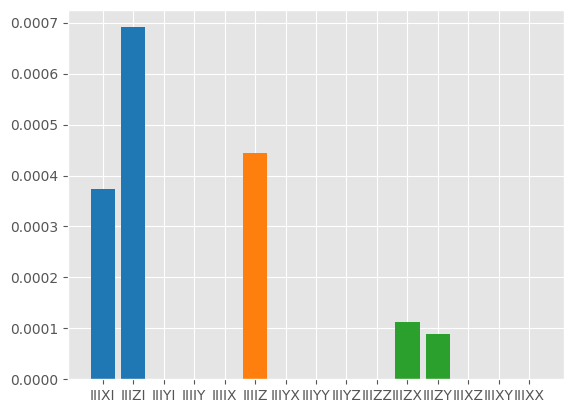

In [26]:
layer1.plot_coeffs((1,),(0,),(0,1))

In [27]:
import pickle
with open("graph.pickle", "wb") as f:
    pickle.dump(results, f)